<a href="https://colab.research.google.com/github/ejshumaker/EECS504Project/blob/work/EECS504FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 Final Project

### Bryan Edwards, Demba Komma, Leah Wu, Eric Shumaker
#### {bryaned, dbkomma, huiminwu, eshumake} @umich.edu


# Starting


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
import cv2
import os
import time

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


Check which GPU Google has allocated

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 17 17:26:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setting up path to training model weights in Drive.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'classifier.pt'
#################################################################
############## CHANGE PATH TO YOUR WEIGHTS FOLDER ###############
PATH = F"/content/gdrive/My Drive/EECS504/Project/Eric's Weights/{model_save_name}" 
#################################################################
save_weights = False # True to save weights after each epoch 
pretrained = False # True to load in weights from classifier.pt file

# Experiment Parameters

In [0]:
# Experiment Parameters
white_mask = True # True for white, False for black
debug_mode = True # True to train with fewer images, False otherwise

## [1] Get Paris_StreetView Dataset

In [0]:
############ CHANGE PATH TO YOUR DRIVE LOCATION FOR EECS504/Project #############
!unzip -uq "/content/gdrive/My Drive/EECS504/Project/Paris_StreetView_Dataset/paris_train_original.zip"
#################################################################################

## [1] Download Pascal VOC 2007 dataset.



In [0]:
# !wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
# !tar -xf VOCtrainval_06-Nov-2007.tar

# [1.1] Process images by masking center region

In [0]:
# Create directory structure for dataloader 
if os.path.exists('./data'):
  ! rm -r ./data
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/train/sub')
os.mkdir('./data/test')
os.mkdir('./data/test/sub')
train_path = './data/train/sub'
test_path = './data/test/sub'

In [0]:
def process_image(img_path, white_mask):
    """
    Resizes and masks image in specified path.

    Input:
    - img_path: path to image
    - mask_color: 1 to set mask to white, 
                  0 to set mask to black

    Output:
    - Image of size (454,227,3) containing resized original image in left half and
      resized, masked image in right half
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256)) # Resize image to (227,227,3)

    tl = int(256/4)       # top left corner of mask
    br = int(256-(256/4)) # bottom right corner of mask

    # Create white mask
    if white_mask:
      mask = np.zeros_like(img)
      mask[tl:br, tl:br, :] = 255
      masked = cv2.bitwise_or(img, mask)
    
    # Create black mask
    else:
      mask = 255 * np.ones_like(img)
      mask[tl:br, tl:br, :] = 0
      masked = cv2.bitwise_and(img, mask)

    # Concatenate original img with masked
    cat = np.hstack((img, masked))
    return cat

In [0]:
# To clean folders
if len(os.listdir(train_path)) != 0:
  for root, dirs, files in os.walk(train_path):
      for img in files:
          os.remove(os.path.join(root, img))

  for root, dirs, files in os.walk(test_path):
      for img in files:
          os.remove(os.path.join(root, img))

In [11]:
# path = './VOCdevkit/VOC2007/JPEGImages'
path = './paris_train_original/'
images = []

for filename in os.listdir(path):
    img = process_image(os.path.join(path, filename), white_mask)
    if img is not None:
        images.append(img)

# Take last 500 images as test data
train = images[:-500]
test = images[-500:]

# Add training images to train directory
if len(os.listdir(train_path)) == 0:
    for i, img in enumerate(train):
        img_path = train_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Train images saved to train directory')
else:
    print('Please empty {} directory.'.format(train_path))

# Add test images to test directory
if len(os.listdir(test_path)) == 0:
    for i, img in enumerate(test):
        img_path = test_path + '/%d.jpg' % (i + 1)
        cv2.imwrite(img_path, img)
    print('Test images saved to test directory')
else:
    print('Please empty {} directory.'.format(test_path))

Train images saved to train directory
Test images saved to test directory


## [2] Build dataloaders for train and test

In [0]:
def load_data(path, subfolder, transform, batch_size, shuffle=True, debug_mode=True):
    """
    Data loader.

    Inputs:
    - path: path of the data.
    - subfolder: subfolder of the data.
    - transform: data transformation.
    - batch_size: the size of the batch
    - shuffle: if true, shuffle the data

    Outputs:
    - torch Dataloader
    """
    direc = path + '/' + subfolder
    dset = datasets.ImageFolder(direc, transform=transform)

    # For debugging faster, truncate data to 2500 images for training and 10 for validating
    if subfolder == 'train':
      dset_sub = Subset(dset, torch.arange(0, 2500))
    elif subfolder == 'test':
      dset_sub = Subset(dset, torch.arange(0, 10))

    if debug_mode:
      dataloader = DataLoader(dset_sub,batch_size=batch_size,shuffle=shuffle)
    else: 
      dataloader = DataLoader(dset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

In [0]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = load_data('./data', 'train', transform, 1, shuffle=True, debug_mode=debug_mode)
test_loader = load_data('./data', 'test', transform, 10, shuffle=False, debug_mode=debug_mode)

#Sample Output used for visualization
test = test_loader.__iter__().__next__()[0]
img_size = test.size()[2]
fixed_y_ = test[:, :, :, 0:img_size]
fixed_x_ = test[:, :, :, img_size:]

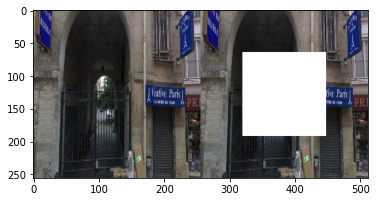

In [15]:
# plot sample image
example = train_loader.__iter__().__next__()[0][0].numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
example = std * example + mean
plt.imshow(example)
plt.show()

## [3] Define Architecture

## RESNET

3.1 Generator Network

In [0]:
def get_res_block(dim=128, ksz=3, s=1):
  
  res = nn.Sequential(
                  nn.ReflectionPad2d(ksz//2),
                  nn.Conv2d(dim, dim, kernel_size=ksz, stride=s), 
                  nn.InstanceNorm2d(dim),
                  nn.ReLU(inplace = True),
                  nn.ReflectionPad2d(ksz//2),
                  nn.Conv2d(dim,dim,kernel_size=ksz, stride=s), 
                  nn.InstanceNorm2d(dim))
  return res

class Generator(nn.Module):
    def __init__(self, in_channels = 3):
        super(Generator, self).__init__()

        ##############################################################################
        # TODO: Build an encoder with the Resnet architecture.           #
        ##############################################################################
        #self.RP = nn.ReflectionPad2d(0)

        self.GC1 = nn.Sequential(
                                nn.ReflectionPad2d(4),
                                nn.Conv2d(3,32, kernel_size=9, stride=1),
                                nn.InstanceNorm2d(32),
                                nn.ReLU(inplace=True),
                                 
                                nn.Conv2d(32,64,kernel_size=3, stride=2, padding = 1),
                                nn.InstanceNorm2d(64),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(64,128, kernel_size=3, stride=2, padding = 1),
                                nn.InstanceNorm2d(128),
                                nn.ReLU(inplace=True))
        
        self.GR1 = get_res_block(dim=128)
        self.GR2 = get_res_block(dim=128)
        self.GR3 = get_res_block(dim=128)
        self.GR4 = get_res_block(dim=128)
        self.GR5 = get_res_block(dim=128)

        self.GC2 = nn.Sequential( 
                                nn.ConvTranspose2d(128,64,kernel_size=3, stride=2, padding = 1, output_padding=1),
                                nn.InstanceNorm2d(64),
                                nn.ReLU(inplace=True),

                                nn.ConvTranspose2d(64,32, kernel_size=3, stride=2, padding = 1, output_padding=1),
                                nn.InstanceNorm2d(32),
                                nn.ReLU(inplace=True),
                                 
                                nn.ReflectionPad2d(4),
                                nn.Conv2d(32,3, kernel_size=9, stride=1),
                                nn.InstanceNorm2d(3),
                                nn.ReLU(inplace=True))
        #self._initialize_weights()
        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            '''
            elif isinstance(m, nn.InstanceNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            '''

    def forward(self, x):
        '''
        Given an image x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            out: torch.tensor
        '''
        #yrf  = self.RP(x)
        ygc1 = self.GC1(x)
        ygr1 = self.GR1(ygc1) + ygc1
        ygr2 = self.GR2(ygr1) + ygr1
        ygr3 = self.GR2(ygr2) + ygr2
        ygr4 = self.GR2(ygr3) + ygr3
        ygr5 = self.GR2(ygr4) + ygr4
        out  = self.GC2(ygr5)
        return out

In [17]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
generator = Generator().to(device)
summary(generator, [(3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 264, 264]               0
            Conv2d-2         [-1, 32, 256, 256]           7,808
    InstanceNorm2d-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-6         [-1, 64, 128, 128]               0
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-9          [-1, 128, 64, 64]               0
             ReLU-10          [-1, 128, 64, 64]               0
  ReflectionPad2d-11          [-1, 128, 66, 66]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
   InstanceNorm2d-13          [-1, 128, 64, 64]               0
             ReLU-14          [-1, 128,

3.2 Decoder

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 6, feat_dim=32):
        super(Discriminator, self).__init__()

        ##############################################################################
        # TODO: Build the decoder as specified above.                                #
        ##############################################################################  
        self.D_shared = nn.Sequential(
                        nn.Conv2d(in_channels, feat_dim, kernel_size=9, stride=1, padding=4),
                        nn.InstanceNorm2d(feat_dim), 
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(feat_dim, 64,kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(64),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(128),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(256),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        self.D_pgan =  nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 1, kernel_size=3, stride=1, padding = 1))
        
        self.D_ggan =  nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding = 1),
                        nn.InstanceNorm2d(1024),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),

                        nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding = 1))
        
        #self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            '''
            elif isinstance(m, nn.InstanceNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            '''

        
    def activate_gradients(self, net_gan=3, cond=False):
        """
        Enable or disable  gradients when computing losses
        net_gan = 0  gradients for shared weights
        net_gan = 1  gradients for shared patch gan weights
        net_gan = 2  gradients for shared global gan weights
        net_gan = 3  gradients for all weights
        """
        s_cond, pg_cond, g_cond = cond, cond, cond
        if(net_gan == 0):
            s_cond, pg_cond, g_cond = s_cond, not pg_cond, not g_cond
        elif(net_gan == 1):
            s_cond, pg_cond, g_cond = not s_cond, pg_cond, not g_cond
        elif(net_gan == 2):
            s_cond, pg_cond, g_cond = not s_cond, not pg_cond, g_cond
        elif(net_gan == 3):
            s_cond, pg_cond, g_cond = s_cond, pg_cond, g_cond
        else:
            return

        for param in self.D_shared.parameters():
            param.requires_grad = s_cond
        for param in self.D_pgan.parameters():
            param.requires_grad = pg_cond
        for param in self.D_ggan.parameters():
            param.requires_grad = g_cond
       
     


    def forward(self, x):
        '''
        Given latent representation h, reconstruct an image patch of size 64 x 64.

        Args:
            x: torch.tensor

        Return: 
            yp, yg
            yp: torch.tensor, patch gan output
            yg: torch.tensor, global gan output
        '''
        ys = self.D_shared(x)
        yp = self.D_pgan(ys)
        yg = self.D_ggan(ys)
        return yp, yg

In [0]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
discriminator = Discriminator().to(device)
summary(discriminator, [(6, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]          15,584
    InstanceNorm2d-2         [-1, 32, 256, 256]               0
         LeakyReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-5         [-1, 64, 128, 128]               0
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-8          [-1, 128, 64, 64]               0
         LeakyReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
   InstanceNorm2d-11          [-1, 256, 32, 32]               0
        LeakyReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
   InstanceNorm2d-14          [-1, 512,

3.3 U-Net Autoencoder

In [0]:
class InpaintModel(nn.Module):
    def __init__(self, lm = [0.995, 0.0025, 0.0025]):
        super(InpaintModel, self).__init__()

        self.D = Discriminator()
        self.G = Generator()
        self.G_L1_Loss = nn.L1Loss()
        self.D_PGAN_Loss = nn.BCEWithLogitsLoss()
        self.D_GGAN_Loss = nn.BCEWithLogitsLoss()
        self.G_Optim = optim.Adam(self.G.parameters(), lr=1e-3)
        self.D_PGAN_Optim = optim.Adam(self.D.D_pgan.parameters(), lr = 1e-3)
        self.D_GGAN_Optim = optim.Adam(self.D.D_ggan.parameters(), lr = 1e-3)
        self.D_SGAN_Optim = optim.Adam(self.D.D_shared.parameters(), lr = 1e-3)
        self.x_input = None
        self.y_input = None
        self.y_fake  = None
        self.lm = lm

    def set_inputs(self, x, y):
        self.x_input = x
        self.y_input = y

    def weight_init(self):
        self.D._initialize_weights()
        self.G._initialize_weights()
    
    def forward(self, x = None, y = None):
        #print(self.lm)
        if(x is not None):
            self.x_input = x
            self.y_input = y
        self.y_fake = self.G(self.x_input)
        return self.y_fake

    def pgan_disc(self, pred_real, pred_fake):
        # train pgan weights of discrimminator
        target_true = torch.ones(pred_real.size()).to(device)
        target_false = torch.zeros(pred_fake.size()).to(device)
        loss_d_pgan_fake = self.D_PGAN_Loss(pred_fake, target_false) 
        loss_d_pgan_real = self.D_PGAN_Loss(pred_real, target_true)
        loss_d_pgan = (loss_d_pgan_fake + loss_d_pgan_real)/2.0
        #self.D.activate_gradients(net_gan=1, cond=True)
        self.D_PGAN_Optim.zero_grad();
        loss_d_pgan.backward(retain_graph = True)
        self.D_PGAN_Optim.step()
        #print('Hello PGAN')
        
        return loss_d_pgan

    def ggan_disc(self, pred_real, pred_fake):
        # train ggan weights of discrimminator
        target_true = torch.ones(pred_real.size()).to(device)
        target_false = torch.zeros(pred_fake.size()).to(device)
        loss_d_ggan_fake = self.D_PGAN_Loss(pred_fake, target_false) 
        loss_d_ggan_real = self.D_PGAN_Loss(pred_real, target_true)
        loss_d_ggan = (loss_d_ggan_fake + loss_d_ggan_real)/2.0
        #self.D.activate_gradients(net_gan=2, cond=True)
        self.D_GGAN_Optim.zero_grad();
        loss_d_ggan.backward(retain_graph = True)
        self.D_GGAN_Optim.step()
        #print('Hello GGAN')
        return loss_d_ggan

    def sgan_disc(self, loss_d_ggan, loss_d_pgan):
        # train shared weights of discrimminator
        loss_d_sgan = loss_d_ggan + loss_d_pgan
        #self.D.activate_gradients(net_gan=0, cond=True)
        self.D_SGAN_Optim.zero_grad();
        loss_d_sgan.backward()
        self.D_SGAN_Optim.step()
        #print('Hello SGAN')
        return loss_d_sgan

        
    def train_networks(self):
        self.forward()
        
        #Train discriminator network
        real_x_fake_y = torch.cat((self.x_input, self.y_fake), dim=1)
        real_x_real_y = torch.cat((self.x_input, self.y_input), dim=1)
        pred_fake_pgan, pred_fake_ggan = self.D(real_x_fake_y.detach())
        pred_real_pgan, pred_real_ggan = self.D(real_x_real_y)
        
        #Train PGAN, GGAN, SGAN Network
        loss_d_pgan = self.pgan_disc(pred_real_pgan, pred_fake_pgan)
        loss_d_ggan = self.ggan_disc(pred_real_pgan, pred_fake_pgan)
        loss_d_sgan = self.ggan_disc(loss_d_ggan, loss_d_pgan)


        #train generator
        #first disable discriminator
        #self.D.activate_gradients(net_gan=3, cond=False) 
        loss_g_rec = self.G_L1_Loss(self.y_fake, self.y_input)
        net_loss = self.lm[0]*loss_g_rec + self.lm[1]*loss_d_pgan + self.lm[2]*loss_d_ggan
        self.G_Optim.zero_grad()
        net_loss.backward()
        self.G_Optim.step()
        #print('Train')
        #self.D.activate_gradients(net_gan=3, cond=True)

        return net_loss, loss_d_pgan, loss_d_ggan
    

In [20]:
im_gd = InpaintModel().to(device)
summary(im_gd, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 264, 264]               0
            Conv2d-2         [-1, 32, 256, 256]           7,808
    InstanceNorm2d-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-6         [-1, 64, 128, 128]               0
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-9          [-1, 128, 64, 64]               0
             ReLU-10          [-1, 128, 64, 64]               0
  ReflectionPad2d-11          [-1, 128, 66, 66]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
   InstanceNorm2d-13          [-1, 128, 64, 64]               0
             ReLU-14          [-1, 128,

3.4 Train Autoencoder

## [4] Train



In [0]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(10,30))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 2].get_xaxis().set_visible(False)
        ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
        ax[i, 2].cla()
        ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [0]:
# Hint: you could use following loss to complete following function
#BCE_loss = nn.BCELoss().cuda()
#L1_loss = nn.L1Loss().cuda()

def train(model, num_epochs = 50):
    hist_D_losses = []
    hist_G_losses = []


    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0

        for x_, _ in train_loader:
            
            y_ = x_[:, :, :, 0:img_size]
            x_ = x_[:, :, :, img_size:]
                
            x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())

         
            model.set_inputs(x_, y_)
            net_loss, loss_d_pgan, loss_d_ggan = model.train_networks()

            loss_D = loss_d_pgan + loss_d_ggan
            D_losses.append(loss_D)
            hist_D_losses.append(loss_D)

            loss_G = net_loss 
            G_losses.append(loss_G)
            hist_G_losses.append(loss_G)
            num_iter += 1

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        print('Sample Image:')
        show_result(model.G, Variable(fixed_x_.cuda(), volatile=True), fixed_y_, (epoch+1))

        # Save training parameters after each epoch
        if save_weights:
          torch.save(model, PATH)

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses



In [23]:
# Define network
model = InpaintModel()
model.weight_init()
model.cuda()

#Report the architectures of your network
print(model.G)
print('Number of trainable parameters {}'.format(count_params(model.G)))

print(model.D)
print('Number of trainable parameters {}'.format(count_params(model.D)))

Generator(
  (GC1): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
  )
  (GR1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (

## Load in weights from previous session

In [0]:
if pretrained:
  model = torch.load(PATH)
  model.train()

# Training

training start!
Start training epoch 1
[1/20] - using time: 171.57
loss of discriminator D: 0.447
loss of generator G: 0.403
Sample Image:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


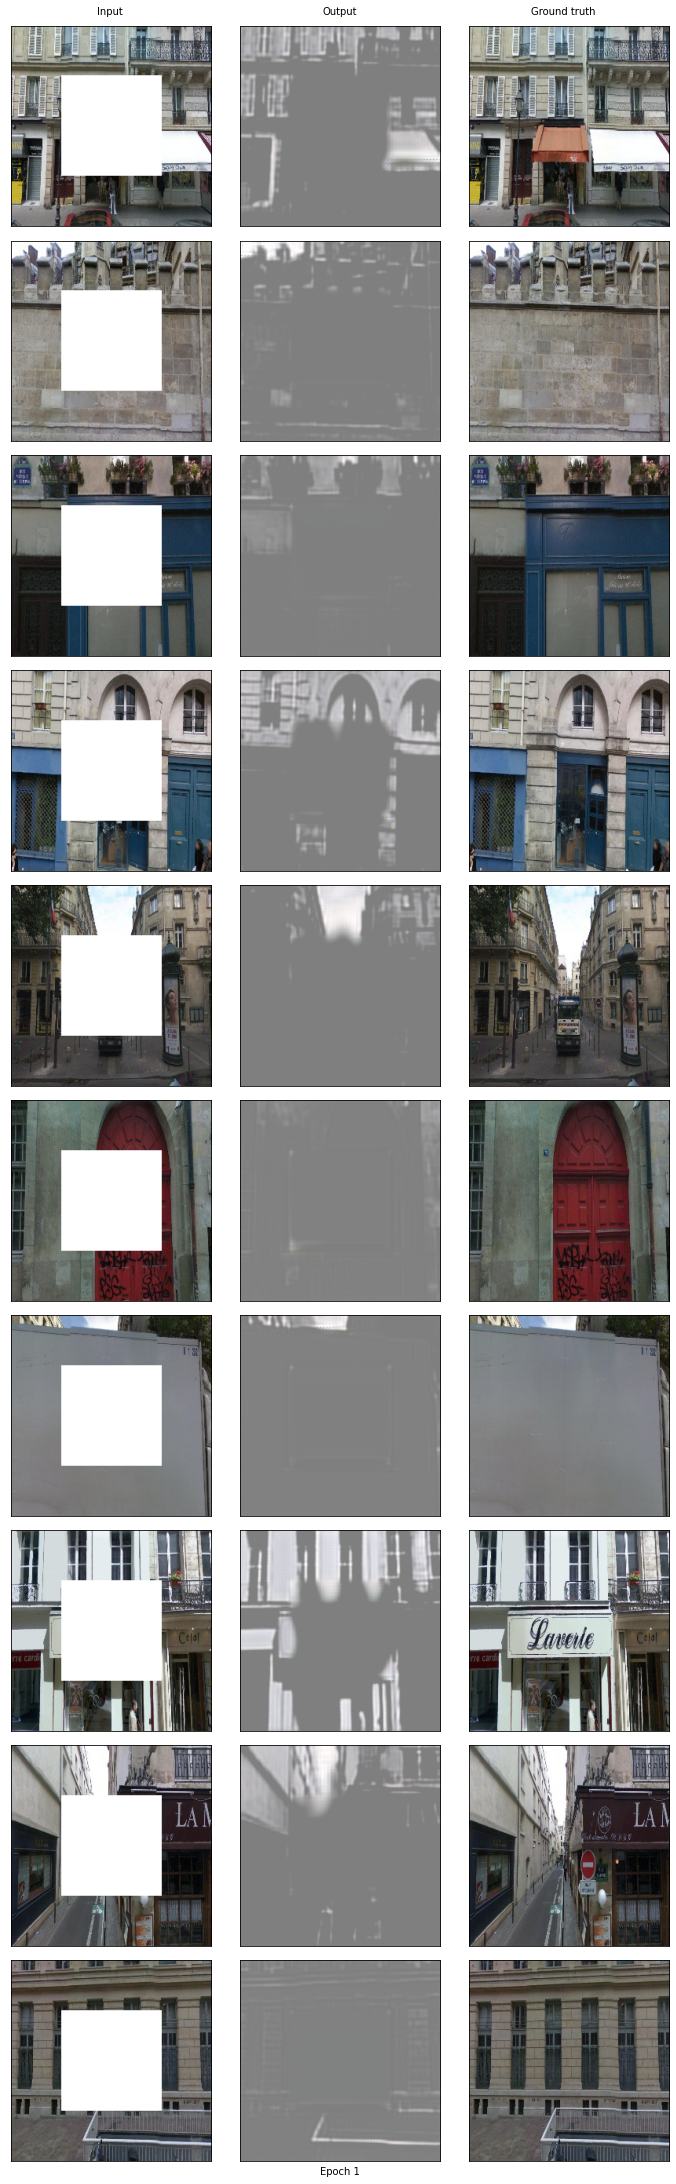

Start training epoch 2
[2/20] - using time: 170.91
loss of discriminator D: 0.054
loss of generator G: 0.388
Sample Image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


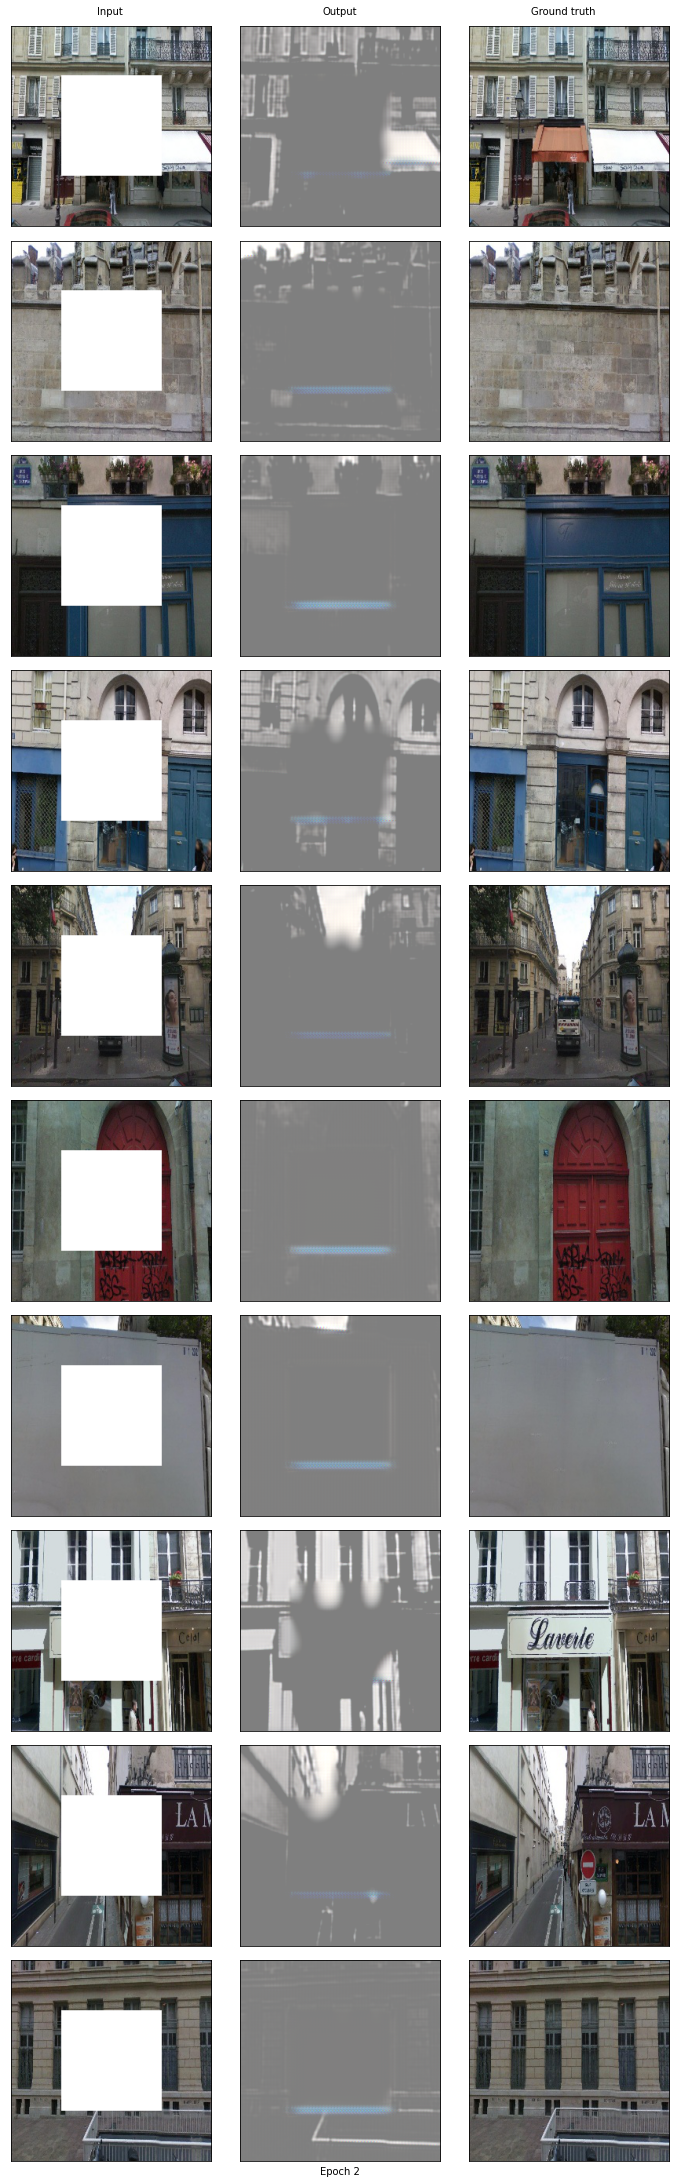

Start training epoch 3


In [0]:
# change_num_epochs
hist_D_losses, hist_G_losses = train(model, num_epochs = 20)

## [5] Visualization

In [0]:
# plot the G/D loss history v.s. Iteration in one plot

num_iter = []
for i in  range(8000):
  num_iter.append(i)

plt.figure()
plt.plot(num_iter, hist_D_losses)
plt.plot(num_iter, hist_G_losses)
plt.legend(['D Loss', 'G Loss'])
plt.xticks(num_iter)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History for G and D vs. Iteration')
plt.show()